<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>Variable Stars in DP0.2</b> <br>
Contact author(s): Jeff Carlin <br>
Last verified to run: 2022-06-24 <br>
LSST Science Piplines version: Weekly 2022_22 <br>
Container Size: medium <br>
Targeted learning level: intermediate <br>

**Description:** Use various catalogs to identify variable stars and plot their lightcurves.

**Skills:** Use various TAP tables, including joining multiple tables. Extract time-series photometry. Measure periods and plot phased lightcurves.

**LSST Data Products:** TAP tables dp02_dc2_catalogs.Object, ForcedSource, CcdVisit, DiaObject, DiaSource

**Packages:** numpy, matplotlib, astropy.units, astropy.coordinates, astropy.io.fits, astropy.timeseries.LombScargle, lsst.rsp.get_tap_service

**Credit:** Originally developed by Jeff Carlin and the Community Engagement Team for Rubin Data Preview 0.
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook demonstrates use of the TAP service to query the time-domain data products at the location of a known RR Lyrae variable star.
The photometry is retrieved from the ForcedSource table, and a Lomb-Scargle periodogram is used to identify the period and phase-fold the time-series photometry.
A phase-folded lightcurve is then displayed for the single RR Lyrae.

This notebook also demonstrates use of the TAP service, and in particular the lightcurve summary statistic parameters available in the DiaObjects table, to identify a sample of likely RR Lyrae from the DP0.2 data set.

### 1.1 Package Imports

In [1]:
# General
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

# Astropy
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.timeseries import LombScargle

# LSST package for TAP queries
from lsst.rsp import get_tap_service

Set up some plotting defaults so plots will look nice:

In [2]:
%matplotlib inline

params = {'axes.labelsize': 24,
          'font.size': 20,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [10, 8],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

### 1.2 Define Functions and Parameters

Set up colors and plot symbols corresponding to the _ugrizy_ bands. These colors are the same as those used for _ugrizy_ bands in Dark Energy Survey (DES) publications, and are defined in <a href="https://github.com/DarkEnergySurvey/descolors">this github repository</a>.

In [3]:
plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

Start the TAP service, which we will use for all data retrieval in this notebook:

In [4]:
service = get_tap_service()

## 2. Create a Lightcurve for a Known RR Lyrae Variable

To start out, we will use a star that is known (from the DC2 truth tables) to be a simulated RR Lyrae star in DC2. This will help us get our feet wet at extracting time-series data and manipulating them.



### 2.1 Extract Forced Photometry Measurements for a Pulsating Variable

The known RR Lyrae star we will use is at position (RA, Dec) = (62.1479031, -35.799138) degrees. We will initially look for this star in the `Object` table to identify its `objectId`. Then we will use this `objectId` to identify measurements of the star in the `ForcedSource` table.

#### 2.1.1 Define star coordinates

Initialize two variables with the known position of the star of interest:

In [5]:
ra_known_rrl = 62.1479031
dec_known_rrl = -35.799138

#### 2.1.2 Find the Star in the Object Table

Query the `Object` table for this star. We use a spatial query at the RA, Dec position of interest, and specify a very small area to search (0.001 degrees), so that we will retrieve only the star of interest.

Notice that in addition to selecting on position, we specify "detect_isPrimary = 1" as well. The <a href="https://pipelines.lsst.io/getting-started/multiband-analysis.html#filtering-for-unique-deblended-sources-with-the-detect-isprimary-flag">detect_isPrimary flag</a> is a composite flag that, if TRUE (or set to 1), ensures a unique, deblended source.

Notice also the use of the `scisql_nanojanskyToAbMag` function to convert fluxes to magnitudes. (This could also be done after extracting the fluxes if desired, but this step streamlines things.)

In [27]:
results = service.search("SELECT coord_ra, coord_dec, objectId, "
                         "g_psfFlux, r_psfFlux, i_psfFlux, detect_isPrimary, "
                         "scisql_nanojanskyToAbMag(g_psfFlux) as gPSFMag, "
                         "scisql_nanojanskyToAbMag(r_psfFlux) as rPSFMag, "
                         "scisql_nanojanskyToAbMag(i_psfFlux) as iPSFMag, "
                         "g_extendedness, r_extendedness, i_extendedness "
                         "FROM dp02_dc2_catalogs.Object "
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "
                         "CIRCLE('ICRS'," + str(ra_known_rrl) + ", "
                         + str(dec_known_rrl) + ", 0.001)) = 1 "
                         "AND detect_isPrimary = 1", maxrec=100000)

objs = results.to_table()

In [28]:
objs

coord_ra,coord_dec,objectId,g_psfFlux,r_psfFlux,i_psfFlux,detect_isPrimary,gPSFMag,rPSFMag,iPSFMag,g_extendedness,r_extendedness,i_extendedness
deg,deg,,nanojansky,nanojansky,nanojansky,,,,,,,
float64,float64,int64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64
62.1479018,-35.7991382,1651589610221899038,148048.9327607,185964.3848651,173109.3517536,True,18.473986797397433,18.226425555283118,18.304198674833767,0.0,0.0,0.0


Looks good - our limited search retrieved only a single object. Notice that the "extendedness" flag is zero for all three bands, meaning this object is likely a point source (i.e., a star). It is around 18th magnitude in all three bands, and has fairly blue colors as expected for an RR Lyrae star.

#### 2.1.3 Extract the Measurements from the Forced Source Table

Now that we have identified the candidate in the Object table, we can use its `objectId` to identify it in the `ForcedSource` table. First extract the `objectId`:

In [29]:
sel_objid = objs[0]['objectId']
print(sel_objid)

1651589610221899038


Now we will use this ID to pick out all measurements of this object from the `ForcedSource` table (by use of a WHERE statement in the query).

Note that we are also using a JOIN here to extract the visit info for each entry in `ForcedSource`. This is necessary so we can get the time each exposure was observed ("expMidptMJD"), to be used in constructing lightcurves.

In [30]:
# Define the query
query = "SELECT src.band, src.ccdVisitId, src.coord_ra, src.coord_dec, "\
        "src.objectId, src.psfFlux, src.psfFluxErr, "\
        "scisql_nanojanskyToAbMag(psfFlux) as psfMag, "\
        "visinfo.ccdVisitId, visinfo.band, "\
        "visinfo.expMidptMJD, visinfo.zeroPoint "\
        "FROM dp02_dc2_catalogs.ForcedSource as src "\
        "JOIN dp02_dc2_catalogs.CcdVisit as visinfo "\
        "ON visinfo.ccdVisitId = src.ccdVisitId "\
        "WHERE src.objectId = "+str(sel_objid)+" "


Execute the query, and extract the results to a table:

In [31]:
results = service.search(query)
srcs = results.to_table()
print(len(srcs))

432


Uncomment and execute the following cell to see what this table looks like.

In [32]:
# srcs

#### 2.1.4 Select Forced Photometry Measurements from Each Band

The `ForcedSource` table contains measurements from all bands (i.e., _ugrizy_ filters). It will be useful to extract measurements for each band by selecting on the "band" column.

In [33]:
picku = (srcs['band'] == 'u')
pickg = (srcs['band'] == 'g')
pickr = (srcs['band'] == 'r')
picki = (srcs['band'] == 'i')
pickz = (srcs['band'] == 'z')
picky = (srcs['band'] == 'y')

Plot the observed "lightcurve" for the _r_ band.

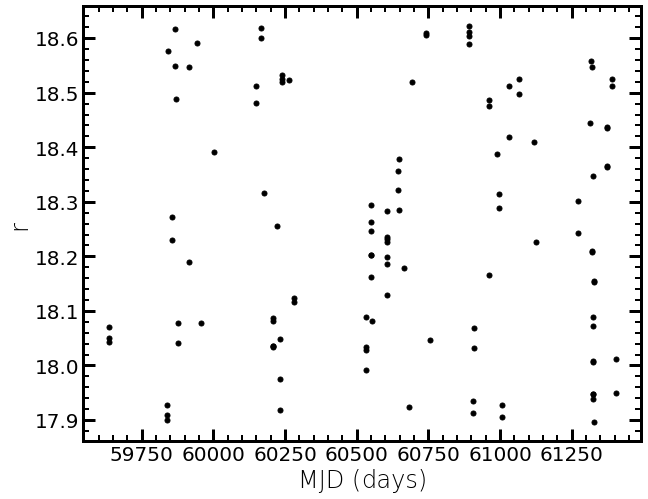

In [34]:
plt.plot(srcs[pickr]['expMidptMJD'], srcs[pickr]['psfMag'],
         'k.', ms=10)
plt.minorticks_on()
plt.xlabel('MJD (days)')
plt.ylabel('r')
plt.show()

There is a spread of almost 1 magnitude, so clearly we have identified a variable star. Hooray!

### 2.2 Create a Phased Lightcurve

In the plot above, it is clear that this is a variable star, but we want to know more about it. Assuming it is a periodic variable, let's try to estimate its period so we can create a phased lightcurve.

_CAVEAT: The author of this notebook is not an expert in periodic variables or analysis of time-series data. The following is almost certainly not the **best** way of doing these analyses, but is simply one way to do things. It is shown here as a demonstration only._

A common way of searching for periodicity in unevenly-sampled time-series data is the Lomb-Scargle Periodogram. In this section we will create such a periodogram using the <a href="https://docs.astropy.org/en/stable/timeseries/lombscargle.html">Lomb-Scargle package from Astropy</a>. We will then estimate the best period, and reference all observations to that period to create a phased lightcurve.


#### 2.2.1 Extract and Plot a Periodogram

For convenience, we first extract all of the times of observation and measured magnitudes to separate arrays for each bandpass.

In [35]:
umjd_days = np.array(srcs[picku]['expMidptMJD']) * u.day
umags = np.array(srcs[picku]['psfMag'])
gmjd_days = np.array(srcs[pickg]['expMidptMJD']) * u.day
gmags = np.array(srcs[pickg]['psfMag'])
rmjd_days = np.array(srcs[pickr]['expMidptMJD']) * u.day
rmags = np.array(srcs[pickr]['psfMag'])
imjd_days = np.array(srcs[picki]['expMidptMJD']) * u.day
imags = np.array(srcs[picki]['psfMag'])
zmjd_days = np.array(srcs[pickz]['expMidptMJD']) * u.day
zmags = np.array(srcs[pickz]['psfMag'])
ymjd_days = np.array(srcs[picky]['expMidptMJD']) * u.day
ymags = np.array(srcs[picky]['psfMag'])

The Lomb-Scargle periodogram returns the power at different frequencies. Because we know this is an RR Lyrae star, its period must be between ~0.2-0.9 days. We will use the min/max frequency settings to limit our period search to 0.05-1.05 days. (Recall that frequency is 1/period.)

In [36]:
min_period = 0.05 * u.day
max_period = 1.05 * u.day

min_freq_search = 1.0 / max_period
max_freq_search = 1.0 / min_period

Now we run the LombScargle algorithm on each of these datasets. We will set only the min/max frequencies, and otherwise use the "autopower" method from LombScargle. 

In [37]:
ufrequency, upower = LombScargle(umjd_days, umags).autopower(minimum_frequency=min_freq_search,
                                                             maximum_frequency=max_freq_search)
gfrequency, gpower = LombScargle(gmjd_days, gmags).autopower(minimum_frequency=min_freq_search,
                                                             maximum_frequency=max_freq_search)
rfrequency, rpower = LombScargle(rmjd_days, rmags).autopower(minimum_frequency=min_freq_search,
                                                             maximum_frequency=max_freq_search)
ifrequency, ipower = LombScargle(imjd_days, imags).autopower(minimum_frequency=min_freq_search,
                                                             maximum_frequency=max_freq_search)
zfrequency, zpower = LombScargle(zmjd_days, zmags).autopower(minimum_frequency=min_freq_search,
                                                             maximum_frequency=max_freq_search)
yfrequency, ypower = LombScargle(ymjd_days, ymags).autopower(minimum_frequency=min_freq_search,
                                                             maximum_frequency=max_freq_search)

In a well-behaved and well-sampled scenario, the Lomb-Scargle power will peak at a specific frequency that corresponds to the period of the star's variability.

We will assume that the frequency returning the highest power corresponds to the real period of the star (which is not necessarily true in the case of real data with uneven sampling, period aliasing, and other effects). Let's find this frequency for each band:

In [38]:
peak_freqs = {}
all_peak_freqs = []

for band in plot_filter_labels:
    # Select the index of the peak in power:
    peakStr = "peakbin = np.argmax("+band+"power)"
    exec(peakStr)
    # Select the corresponding frequency
    peak_freqs[band+"_peakbin"] = peakbin
    freqStr = "peakfreq = "+band+"frequency[peakbin]"
    exec(freqStr)
    peak_freqs[band+"_peakfreq"] = peakfreq
    all_peak_freqs.append(peakfreq.value)

# Convert the frequencies from a list to and array:
all_peak_freqs = np.array(all_peak_freqs)
# Calculate the mean of the "best-fit" frequencies:
mean_peak_freq = np.mean(all_peak_freqs)

print('Mean frequency:', mean_peak_freq)
print('Mean period:', 1.0/mean_peak_freq, ' days')
print('\nugrizy frequency results:\n', all_peak_freqs)


Mean frequency: 1.962589383860051
Mean period: 0.5095309330743371  days

ugrizy frequency results:
 [1.96261051 1.96261062 1.96261288 1.96252393 1.96255106 1.9626273 ]


Plot a "periodogram" -- a figure showing the power vs. frequency from the Lomb-Scargle analysis. We'll also add a panel for the period. (This figure shows only the r-band results. You could try it with others!)

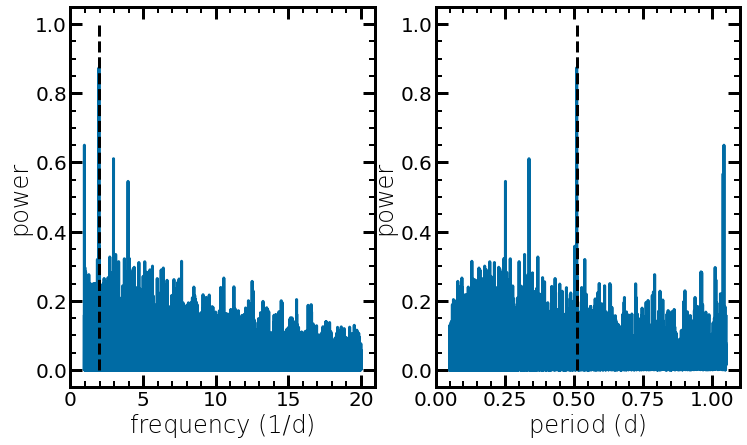

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))

plt.sca(ax[0])  # set the first axis as current

plt.plot(rfrequency, rpower)
plt.vlines(mean_peak_freq, 0, 1, linestyle='--', color='black')
plt.minorticks_on()
plt.xlabel('frequency (1/d)')
plt.ylabel('power')

plt.sca(ax[1])  # set the second axis as current
plt.plot(1 / rfrequency, rpower)
plt.vlines(1/mean_peak_freq, 0, 1, linestyle='--', color='black')
plt.minorticks_on()
plt.xlabel('period (d)')
plt.ylabel('power')
plt.show()

#### 2.2.2 Create a Phased Lightcurve

The red line we overlaid on the previous plot corresponds to a clear peak in the periodogram, so it looks like we have found a good estimate of the period. Now we will use that period to extract and plot phased light-curves of the variable star.

Recall that period = 1/frequency:

In [65]:
best_period = 1/mean_peak_freq

To "phase" the lightcurves, we calculate how many periods have passed since some fiducial time "t0". Here, we select t0 to be the time of the first g-band observation, but that is completely arbitrary.

The second part takes only the non-integer part of the number of elapsed periods. For example, a point that happens 2.75 periods after t0 will have phase 0.75.

In [66]:
# Number of elapsed periods since the first measurement:
t0 = np.min(gmjd_days.value)

umjd_norm = (umjd_days.value - t0) / best_period
gmjd_norm = (gmjd_days.value - t0) / best_period
rmjd_norm = (rmjd_days.value - t0) / best_period
imjd_norm = (imjd_days.value - t0) / best_period
zmjd_norm = (zmjd_days.value - t0) / best_period
ymjd_norm = (ymjd_days.value - t0) / best_period

# Calculate phase by using the modulus function:
uphase = np.mod(umjd_norm, 1.0)
gphase = np.mod(gmjd_norm, 1.0)
rphase = np.mod(rmjd_norm, 1.0)
iphase = np.mod(imjd_norm, 1.0)
zphase = np.mod(zmjd_norm, 1.0)
yphase = np.mod(ymjd_norm, 1.0)

Now plot them separately for each band (using an integer offset to separate them):

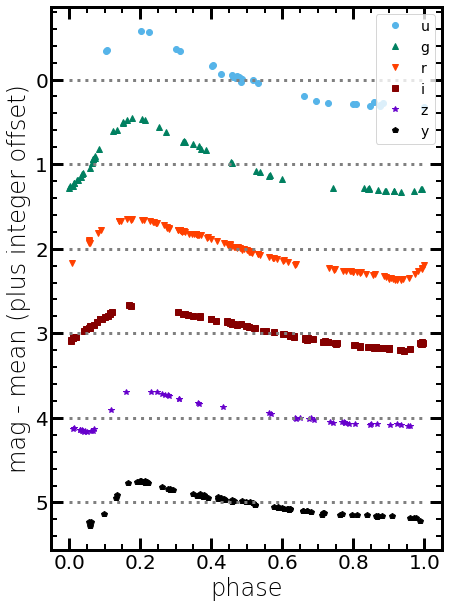

In [67]:
fig = plt.figure(figsize=(7, 10))     # create a matplotlib.pyplot figure

plt.plot(uphase, umags-np.mean(umags), plot_filter_symbols['u'],
         color=plot_filter_colors['u'], label='u')
plt.hlines(0, 0, 1, linestyle=':', color='Gray')
plt.plot(gphase, gmags-np.mean(gmags)+1, plot_filter_symbols['g'],
         color=plot_filter_colors['g'], label='g')
plt.hlines(1, 0, 1, linestyle=':', color='Gray')
plt.plot(rphase, rmags-np.mean(rmags)+2, plot_filter_symbols['r'],
         color=plot_filter_colors['r'], label='r')
plt.hlines(2, 0, 1, linestyle=':', color='Gray')
plt.plot(iphase, imags-np.mean(imags)+3, plot_filter_symbols['i'],
         color=plot_filter_colors['i'], label='i')
plt.hlines(3, 0, 1, linestyle=':', color='Gray')
plt.plot(zphase, zmags-np.mean(zmags)+4, plot_filter_symbols['z'],
         color=plot_filter_colors['z'], label='z')
plt.hlines(4, 0, 1, linestyle=':', color='Gray')
plt.plot(yphase, ymags-np.mean(ymags)+5, plot_filter_symbols['y'],
         color=plot_filter_colors['y'], label='y')
plt.hlines(5, 0, 1, linestyle=':', color='Gray')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('phase')
plt.ylabel('mag - mean (plus integer offset)')
plt.minorticks_on()
plt.show()

...and all together:

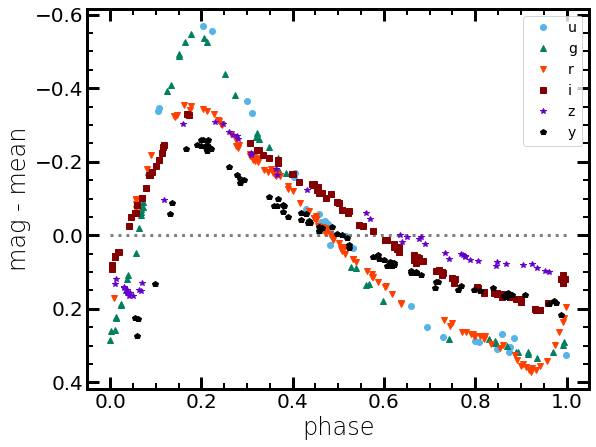

In [68]:
fig = plt.figure(figsize=(9, 7))     # create a matplotlib.pyplot figure

plt.plot(uphase, umags-np.mean(umags), plot_filter_symbols['u'],
         color=plot_filter_colors['u'], label='u')
plt.hlines(0, 0, 1, linestyle=':', color='Gray')
plt.plot(gphase, gmags-np.mean(gmags), plot_filter_symbols['g'],
         color=plot_filter_colors['g'], label='g')
plt.plot(rphase, rmags-np.mean(rmags), plot_filter_symbols['r'],
         color=plot_filter_colors['r'], label='r')
plt.plot(iphase, imags-np.mean(imags), plot_filter_symbols['i'],
         color=plot_filter_colors['i'], label='i')
plt.plot(zphase, zmags-np.mean(zmags), plot_filter_symbols['z'],
         color=plot_filter_colors['z'], label='z')
plt.plot(yphase, ymags-np.mean(ymags), plot_filter_symbols['y'],
         color=plot_filter_colors['y'], label='y')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('phase')
plt.ylabel('mag - mean')
plt.minorticks_on()
plt.show()

Success! That looks like an RR Lyrae star. 

## 3. Identify candidate RR Lyrae From Catalogs

Now that we know we can extract a lightcurve, find the star's period, and plot phased lightcurves for a _known_ RR Lyrae star, we move on to exploring how to _find_ candidate variables based on data in the catalogs.

Data products from difference image analysis (DIA, where sources are detected and measured on the _difference_ image resulting from subtracting an approriately scaled deep coadd template of the same sky area from a single visit image) are a good place to check for transient and variable objects. The two DIA products we will use are:

- **DiaSource**: catalog of sources detected and measured on each visit image after subtracting the appropriate template
- **DiaObject**: "summary" catalog of all unique objects detected on all difference images (essentially a superset containing all unique sources from DiaSource)

The DiaObject table has some summary statistics for each object, which we can use to identify candidate variables.

### 3.1 Query DiaObject and DiaSource to Retrieve Candidates

The DiaObject table has several parameters that characterize the variability of DiaSource flux measurements (see the <a href="https://dm.lsst.org/sdm_schemas/browser/dp02.html#DiaObject">DP0.2 Schema Browser</a> for a full list).
These include the min/max fluxes, and various statistical measures of the scatter in flux measurements.
A particularly useful statistic for variable stars in the "StetsonJ" statistic, based on <a href="https://ui.adsabs.harvard.edu/abs/1996PASP..108..851S/abstract">this 1996 paper</a>.
Variable stars have flux that varies more than expected based on the measurement errors.
High values of the StetsonJ index should identify objects whose fluxes varied much more than expected -- i.e., variable stars.
Here we use StetsonJ>20, but users are encouraged to explore this and other statistics.

Here are all of the criteria we apply to our selection from `DiaObject`:

 1. g-band measurements only
 2. sigma_flux/flux > 0.25 -- the scatter in measured fluxes is larger than 25% relative to the mean
 3. sigma_flux/flux < 1.25 -- the scatter in measured fluxes is no larger than 125% relative to the mean
 4. 18 < gmag < 23 -- mean g magnitude between 18-23
 5. gPSFluxNdata > 30 -- at least 30 observations in g band
 6. gPSFluxStetsonJ > 20 -- StetsonJ index greater than 20
 7. within 5 degrees of our chosen RA, Dec position
 
We perform all of these selections in the ADQL portion of the TAP query. Note also that this is performing a table JOIN between DiaObject and DiaSource where all DiaSources corresponding to each DiaObject will be retrieved. If the order of DiaObject and DiaSource was reversed in this JOIN, it would instead return only a single Source for each Object.

In [69]:
query = "SELECT obj.diaObjectId, obj.ra, obj.decl, obj.nDiaSources, "\
        "obj.gPSFluxMin, obj.gPSFluxMax, obj.gPSFluxMean, obj.gPSFluxSigma, "\
        "obj.gPSFluxMAD, obj.gPSFluxChi2, obj.gPSFluxNdata, obj.gPSFluxSkew, "\
        "obj.gPSFluxStetsonJ, obj.gPSFluxPercentile05, obj.gPSFluxPercentile25, "\
        "obj.gPSFluxPercentile50, obj.gPSFluxPercentile75, obj.gPSFluxPercentile95, "\
        "obj.gTOTFluxMean, obj.gTOTFluxSigma, "\
        "scisql_nanojanskyToAbMag(obj.gTOTFluxMean) as gmag_obj, "\
        "src.diaSourceId, src.diaObjectId, src.midPointTai, "\
        "src.ccdVisitId, src.filterName, src.psFlux, src.psFluxErr, "\
        "src.totFlux, src.totFluxErr, "\
        "scisql_nanojanskyToAbMag(src.totFlux) as gmag "\
        "FROM dp02_dc2_catalogs.DiaObject as obj "\
        "JOIN dp02_dc2_catalogs.DiaSource as src "\
        "ON src.diaObjectId = obj.diaObjectId "\
        "WHERE obj.gTOTFluxSigma/obj.gTOTFluxMean > 0.25 "\
        "AND obj.gTOTFluxSigma/obj.gTOTFluxMean < 1.25 "\
        "AND scisql_nanojanskyToAbMag(obj.gTOTFluxMean) > 18 "\
        "AND scisql_nanojanskyToAbMag(obj.gTOTFluxMean) < 23 "\
        "AND obj.gPSFluxNdata > 30 "\
        "AND obj.gPSFluxStetsonJ > 20 "\
        "AND src.filterName = 'g' "\
        "AND CONTAINS(POINT('ICRS', obj.ra, obj.decl), "\
        "CIRCLE('ICRS',"+str(ra_known_rrl)+", "+str(dec_known_rrl)+", 5.0)) = 1 "

results = service.search(query)
diaSources = results.to_table()

In [70]:
print(len(diaSources), len(np.unique(diaSources['diaObjectId'])))

549 14


The statement and its output above tells us that the query returned 14 unique DiaObjects, with a total of 549 measurements in DiaSource.

### 3.2 Run the Lomb-Scargle Frequency Algorithm on All Candidates

In [71]:
objids = np.unique(diaSources['diaObjectId'])
LSpower = []
LSfreq = []

minfreq = 1 / (1.25*u.d)
maxfreq = 1 / (0.05*u.d)
for objid in objids:
    findobj = (diaSources['diaObjectId'] == objid)
    obj_mjd_days = np.array(diaSources[findobj]['midPointTai']) * u.day
    obj_mags = np.array(diaSources[findobj]['gmag'])
    obj_frequency, obj_power =\
        LombScargle(obj_mjd_days, obj_mags).autopower(minimum_frequency=minfreq,
                                                      maximum_frequency=maxfreq)
    max_power = np.argmax(obj_power)
    LSpower.append(obj_power[max_power])
    LSfreq.append(obj_frequency[max_power].value)

LSpower = np.array(LSpower)
LSfreq = np.array(LSfreq)

### 3.3 Plot Lightcurves

To see if they look like RR Lyrae (and whether we identified the correct period), plot phased lightcurves based on the frequencies from the Lomb-Scargle analysis.

object:  1567428592185376787  RA:  59.4814837  Dec:  -37.7323315  period:  1.0418601712065714


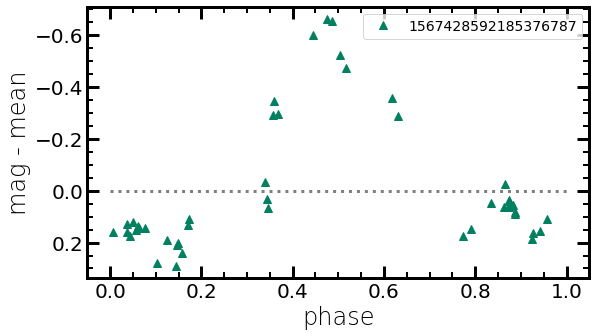

object:  1567762843720221100  RA:  62.5202159  Dec:  -37.8646632  period:  0.6515237959596147


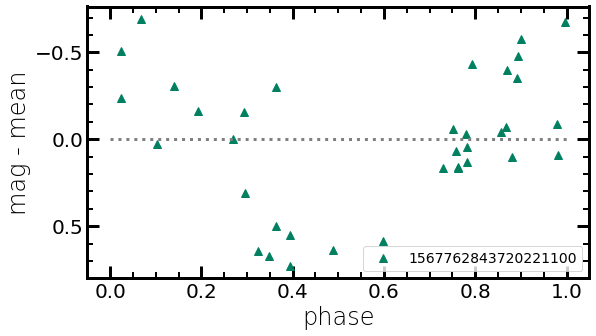

object:  1568246628836442456  RA:  62.5202159  Dec:  -37.8646632  period:  0.6515237959596147


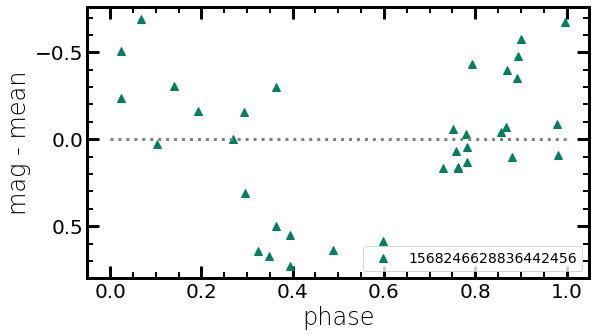

object:  1568950316278219135  RA:  67.2951662  Dec:  -38.4159654  period:  1.25


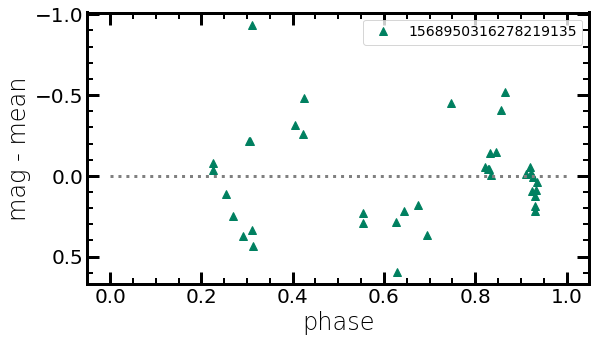

object:  1569082257673552562  RA:  67.0155078  Dec:  -37.8278368  period:  1.25


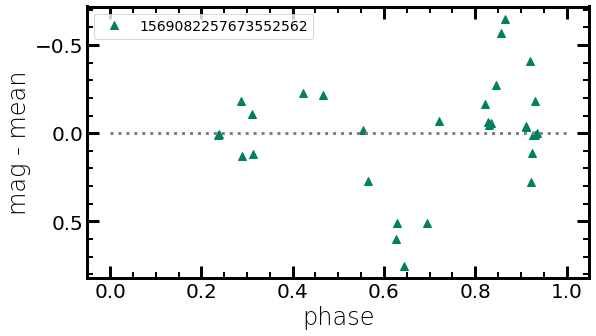

object:  1569135034231685181  RA:  67.4679316  Dec:  -37.6786425  period:  0.5299699323175595


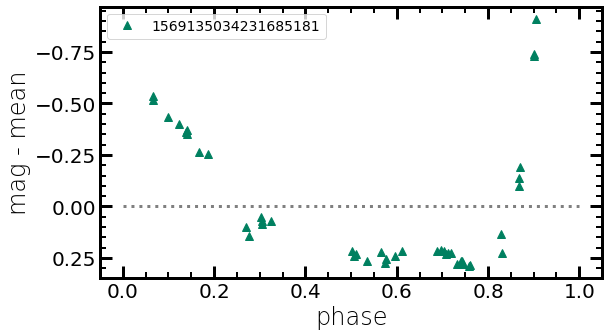

object:  1651510445384663056  RA:  62.6536501  Dec:  -35.9700212  period:  0.34080123268241125


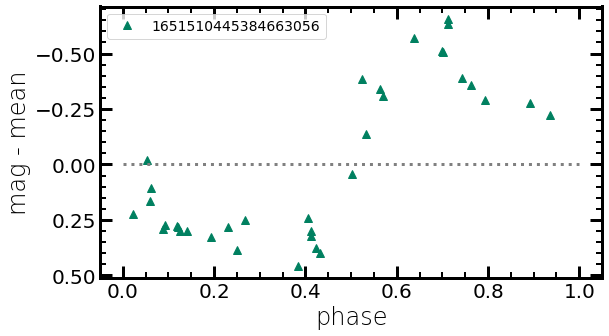

object:  1651589610221862935  RA:  62.1479038  Dec:  -35.7991348  period:  0.5095414310681814


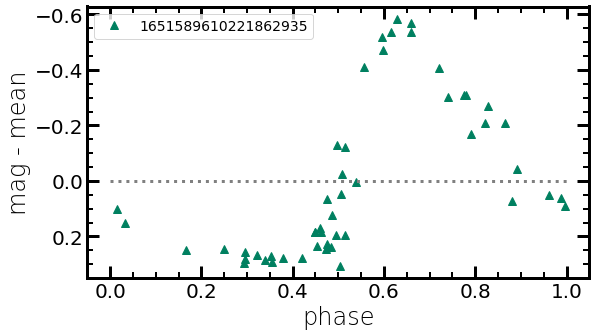

object:  1651739143803240517  RA:  63.2476384  Dec:  -36.91414  period:  0.18627982258404097


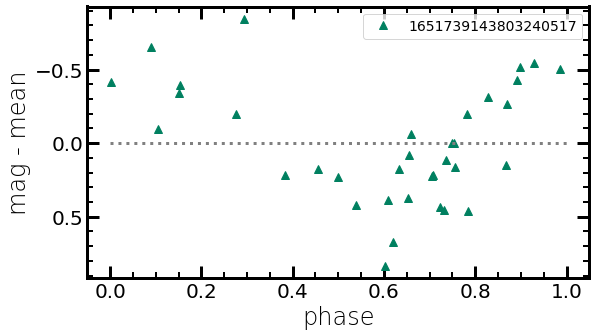

object:  1736208025095503982  RA:  60.2837917  Dec:  -35.4042502  period:  0.503074169899239


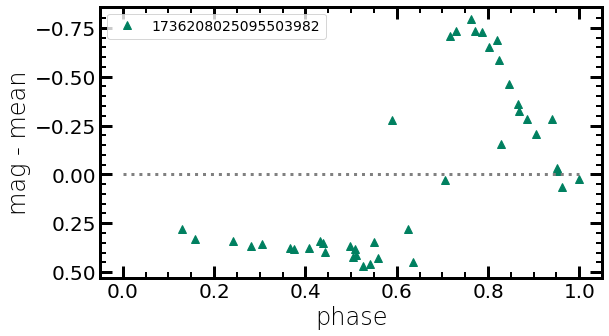

object:  1736726994583814254  RA:  63.2038071  Dec:  -35.0137971  period:  0.23523275038690178


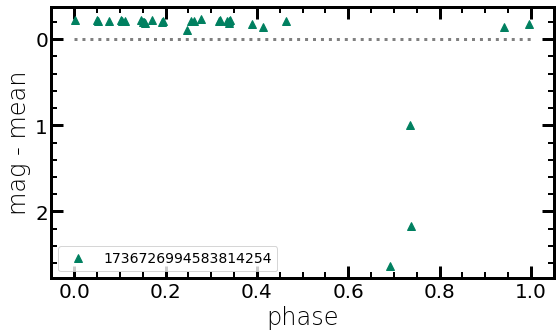

object:  1736858935979147676  RA:  62.9779365  Dec:  -34.5801823  period:  0.06142662047810588


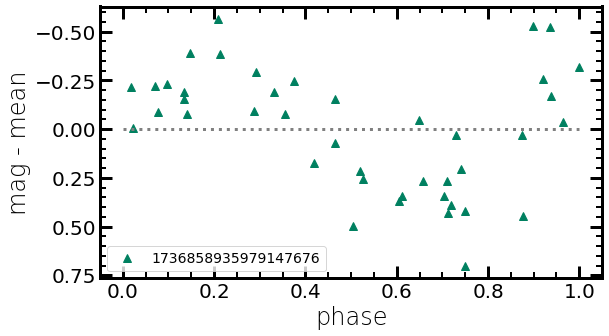

object:  1824520799038472266  RA:  67.7539568  Dec:  -33.9679688  period:  0.60067075552108


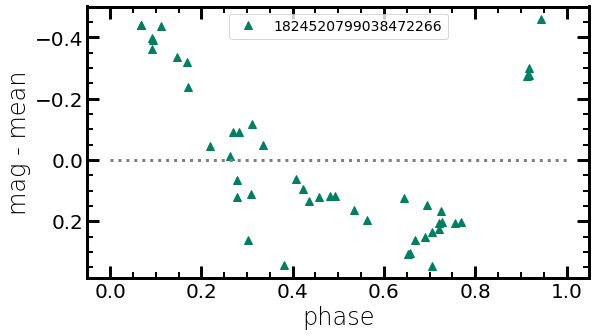

object:  1910977597353754906  RA:  59.6754867  Dec:  -31.5396859  period:  0.9948547859595858


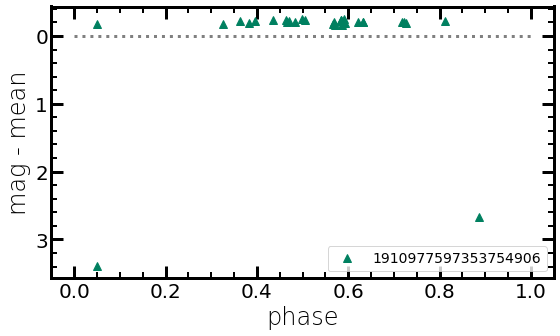

In [72]:
for i in range(len(objids)):
    fig = plt.figure(figsize=(9, 5))     # create a matplotlib.pyplot figure
    findobj = (diaSources['diaObjectId'] == objids[i])
    obj_mjd_days = np.array(diaSources[findobj]['midPointTai']) * u.day
    obj_mags = np.array(diaSources[findobj]['gmag'])
    obj_period = 1 / LSfreq[i]
    print('object: ', objids[i],
          ' RA: ', diaSources[findobj]['ra'][0],
          ' Dec: ', diaSources[findobj]['decl'][0],
          ' period: ', obj_period)
    # Number of elapsed periods since the first measurement:
    t0 = 0.0

    obj_mjd_norm = (obj_mjd_days.value - t0) / obj_period

    # Calculate phase by using the modulus function:
    obj_phase = np.mod(obj_mjd_norm, 1.0)

    plt.plot(obj_phase, obj_mags-np.nanmean(obj_mags), plot_filter_symbols['g'],
             color=plot_filter_colors['g'], ms=8, label=str(objids[i]))
    plt.hlines(0, 0, 1, linestyle=':', color='Gray')

    plt.gca().invert_yaxis()
    plt.legend()
    plt.xlabel('phase')
    plt.ylabel('mag - mean')
    plt.minorticks_on()
    plt.show()

Hooray! A few of these look like actual RR Lyrae variables! Some of the others either aren't RR Lyrae, or have mis-identified periods.

## 4. Exercises for the learner:

There are many further explorations one could try as extensions of this notebook. Some examples:

1. Experiment with ways to identify periodic signals in the data.
2. Compare measurements in DiaSource, ForcedSource, and ForcedSourceOnDiaObjects tables for the same star(s).
3. Refine the selection criteria for finding candidates.

...and many more. Have fun!